# **Workshop 10 - Introduction to Convolutional Neural Networks**

This workshop is divided into sections:

**Parts 1**

In part 1, you will do data loading as inspection, similar to workshop 9.

**Parts 2**

In part 2, you will implement a very simple CNN using Keras.


**Parts 3**

In part 3, you will look at how to translate architectural diagrams into Keras code to implement, and then train, a CNN. Specifically, you will build the network shown in the provided figure (from Lin et al., 2018) in Keras and show the model summary to verify the layer sizes and number of parameters that you have been asked to calculate. Note that the model summary will show the sizes as (...,X,Y,D); that is, depth after spatial size.

You will then use a similar architecture and adapt the code provided in part 2 to perform a classification task using the MNIST dataset.

**Part 4**

In part 4, you will see an example of how to implement early stopping during training.

#**Part 1 [As a class, 15 mins] : Load and inspect data**

Note: Loading and inspecting data is a crucial part of any ML workflow to understand the dataset.

In [ ]:
# Common imports
import numpy as np
import os, time
import pandas as pd
import sklearn

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns; sns.set()

In [ ]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

We will use fashion MNIST, which is a set of small images (28x28) that contain 10 different items (numbers) - see below for class names and an example image.

In [ ]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [ ]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

In [ ]:
# We can check an example of one image
X_train_full[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

float64
float64
4


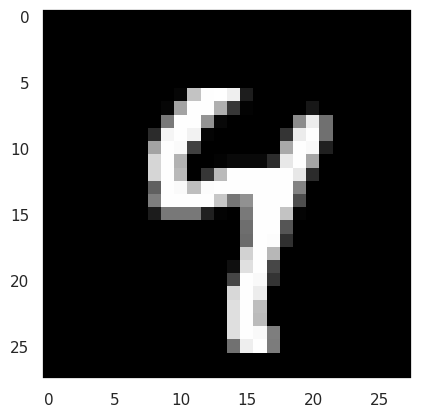

In [ ]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
# Important: This scaling is fixed (dividing by 255), not fitted to data, so there's no data leakage.
# Data leakage is not an issue here because the scaling factor is a constant and does not depend on the dataset.

# We also split the training set given to us into training and validation subsets.
# The value of 5000 samples as the size of the validation set is an arbitrary choice.
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at third item
print(class_names[y_train[2]])
plt.imshow(X_train[2,:,:], cmap='gray')
plt.grid(False)
plt.show()

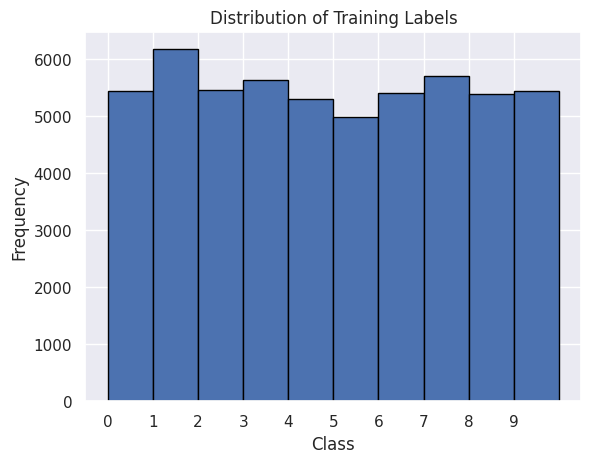

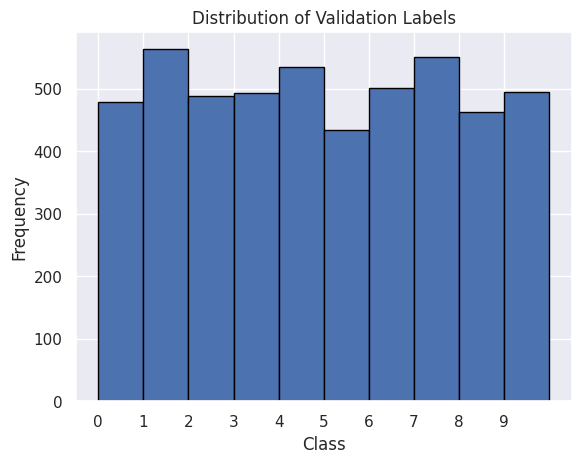

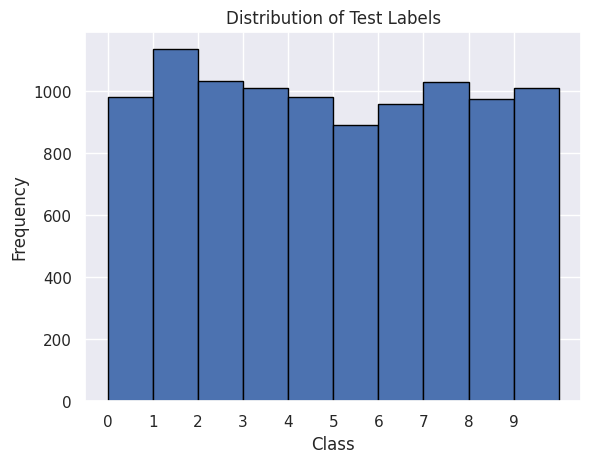

In [ ]:
# Let's look at the distribution of labels in the training, validation and test sets.
# This is part of a best practice pipeline in any classification task.

# Plotting the histogram for y_train
plt.hist(y_train, bins=range(11), edgecolor='black')  # Adjust bins to match the number of classes
plt.title('Distribution of Training Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(10))  # Ensure that x-axis ticks match the class labels
plt.show()

# Plotting the histogram for y_valid
plt.hist(y_valid, bins=range(11), edgecolor='black')  # Adjust bins to match the number of classes
plt.title('Distribution of Validation Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(10))  # Ensure that x-axis ticks match the class labels
plt.show()

# Plotting the histogram for y_test
plt.hist(y_test, bins=range(11), edgecolor='black')  # Adjust bins to match the number of classes
plt.title('Distribution of Test Labels')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(range(10))  # Ensure that x-axis ticks match the class labels
plt.show()


#**Part 2.1 [Students, 15 mins] : Build a Simple Convolutional Neural Network**

Use the code below to build a simple CNN, paying attemtion to the convolution, pooling and flattening layers used. Aftet this, we feed things into a dense layer, and then classify into one of 10 classes. We also apply the softmax function.

Note: Implementing this simple CNN serves to illustrate how such models are built and trained. The focus here is on understanding the architecture rather than optimising the model.

**Questions:**

* How many convolution layers are used, and how many filters applied to each later respectively?
* How many pooling layers are used?
* How many neurons are used in the dense layers? What activation function is used?
* How would you interpret the performance of this simple model?

In [ ]:
# Create a model
model = keras.models.Sequential()
# 1st Conv
model.add(keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation="elu", padding="same",
input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="elu"))                                          # 2nd Conv
model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
model.add(keras.layers.Flatten())                          # unravel into a 1D vector
model.add(keras.layers.Dense(50,activation = "elu"))        # Dense layer
model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes

In [ ]:
# We can check a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 50)               

In [ ]:
# Now, we can compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
# We can train in our model
history = model.fit(X_train,y_train, epochs=5, validation_data=(X_valid, y_valid), batch_size=32)

Epoch 1/5
1719/1719 [==============================] - 27s 15ms/step - loss: 1.7902 - accuracy: 0.5405 - val_loss: 0.9384 - val_accuracy: 0.8000
Epoch 2/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5836 - accuracy: 0.8507 - val_loss: 0.4052 - val_accuracy: 0.8880
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.3709 - accuracy: 0.8925 - val_loss: 0.3172 - val_accuracy: 0.9090
Epoch 4/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3097 - accuracy: 0.9096 - val_loss: 0.2742 - val_accuracy: 0.9206
Epoch 5/5
1719/1719 [==============================] - 24s 14ms/step - loss: 0.2729 - accuracy: 0.9203 - val_loss: 0.2451 - val_accuracy: 0.9260


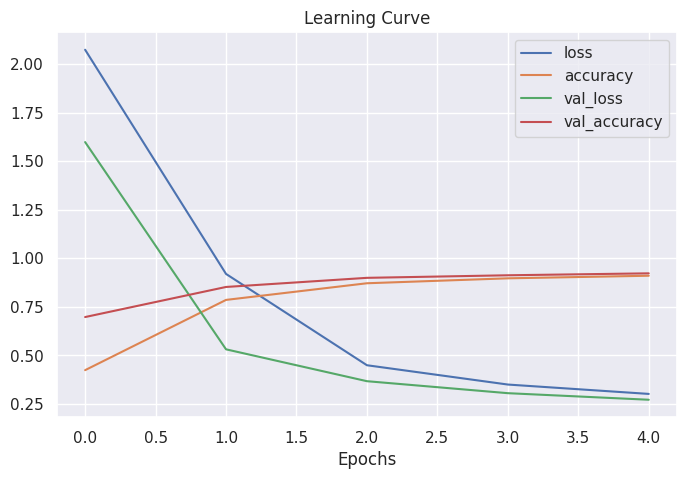

In [ ]:
# We can check the peformance of our model in a plot
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.grid(True)  # Optional: add grid for better readability
plt.legend(loc='best')  # Optional: place legend in the best position
plt.show()

#**Part 2.2 [As a class, 15 mins] : Discuss Building a Simple Convolutional Neural Network**

**Answers:**

* **How many convolution layers are used, and how many filters applied to each later respectively?**

The model uses two convolutional layers. The first convolutional layer applies 16 filters, and the second convolutional layer applies 32 filters. Each layer is followed by an Exponential Linear Unit (ELU) activation function and uses 'same' padding to maintain the spatial dimensions of the input.


* **How many pooling layers are used?**

The model uses two max-pooling layers. Each max-pooling layer reduces the spatial dimensions by a factor of 2, helping to downsample the input and reduce the computational load.


* **How many neurons are used in the dense layers? What activation function is used?**

The model includes one fully connected (dense) layer with 50 neurons and an ELU activation function. This is followed by an output layer with 10 neurons (one for each class in the MNIST dataset) and a softmax activation function to output class probabilities.


* **How would you interpret the performance of this simple model?**

*Model Learning*: The rapid decrease in training loss and increase in training accuracy indicate that the model is effectively learning the patterns in the training data.


*Generalisation*: The validation loss and accuracy follow the trends of the training metrics, suggesting that the model is generalising well to the validation data. This is a positive sign, as it indicates that the model is not just memorising the training data but is able to perform well on unseen data.


# **Part 3.1 [Students, 15 mins]: Calculate the number of parameters needed for the CNN architecture shown in the figure**

One of the main advantages of CNNs, as opposed to densely connected networks, is their efficiency when applied to structured inputs such as images. This efficiency is mostly due to the reduced number of parameters that are needed to define the CNN.

In a densely connected network, the parameters are represented as direct node-to-node connections or weights. In a CNN, it is the values within each convolutional filter (plus the bias value) that are the parameters, since pooling layers do not have any parameters.

For example, the number of parameters in a 3x3 filter that operates on 8 input channels is 3*3*8+1=73. If there are 16 of these filters that act to create the next hidden layer (which will therefore have 16 channels), the total number of parameters (for this layer) is 16*73=1168.

The number of parameters in the convolutional layers of a CNN is therefore independent of the size of the images, and is much smaller than the number of parameters that would be used in a densely connected layer. In a whole CNN, the total number of parameters is the sum of the parameters from each convolutional layer, plus the number of parameters in any densely connected layers at the end. Often the number of parameters in the final densely connected layers can dominate the total number of parameters.

As the number of parameters determines how much data is needed to train the network effectively, it is important to keep a check on the size of the densely connected layers to avoid these adding too many parameters.



###**Calculate number of parameters in the model**

As mentioned at the beginning of the notebook, here you will build the network shown in the provided figure (from Lin et al., 2018) in Keras and show the model summary to verify the layer sizes and number of parameters that you have been asked to calculate. Note that the model summary will show the sizes as (...,X,Y,D); that is, depth after spatial size.


**Task:**

Calculate the number of parameters in several filtering and pooling layers. This is an important consideration when designing your network architecture.

In the figure below, the size of each layer is specified as "D @ X x Y" where D is depth and X and Y are the image dimensions in the respective axes. Each convolution uses a kernel with a 3x3 spatial size. After flattening, the size of the layer is specified as a single number since, at that point, it is just a 1D vector.

* From the figure, work out the number of parameters associated with each layer.
* What layer has the most parameters?
* What proportion of the total number of parameters are contained in the final densely connected section?
* If the input image size was doubled (in each dimension) what would happen to the size of each layer (keeping all other operations the same) and the number of parameters?

Write down your answers and then check them against the information provided in the workshop or 'solution' file.


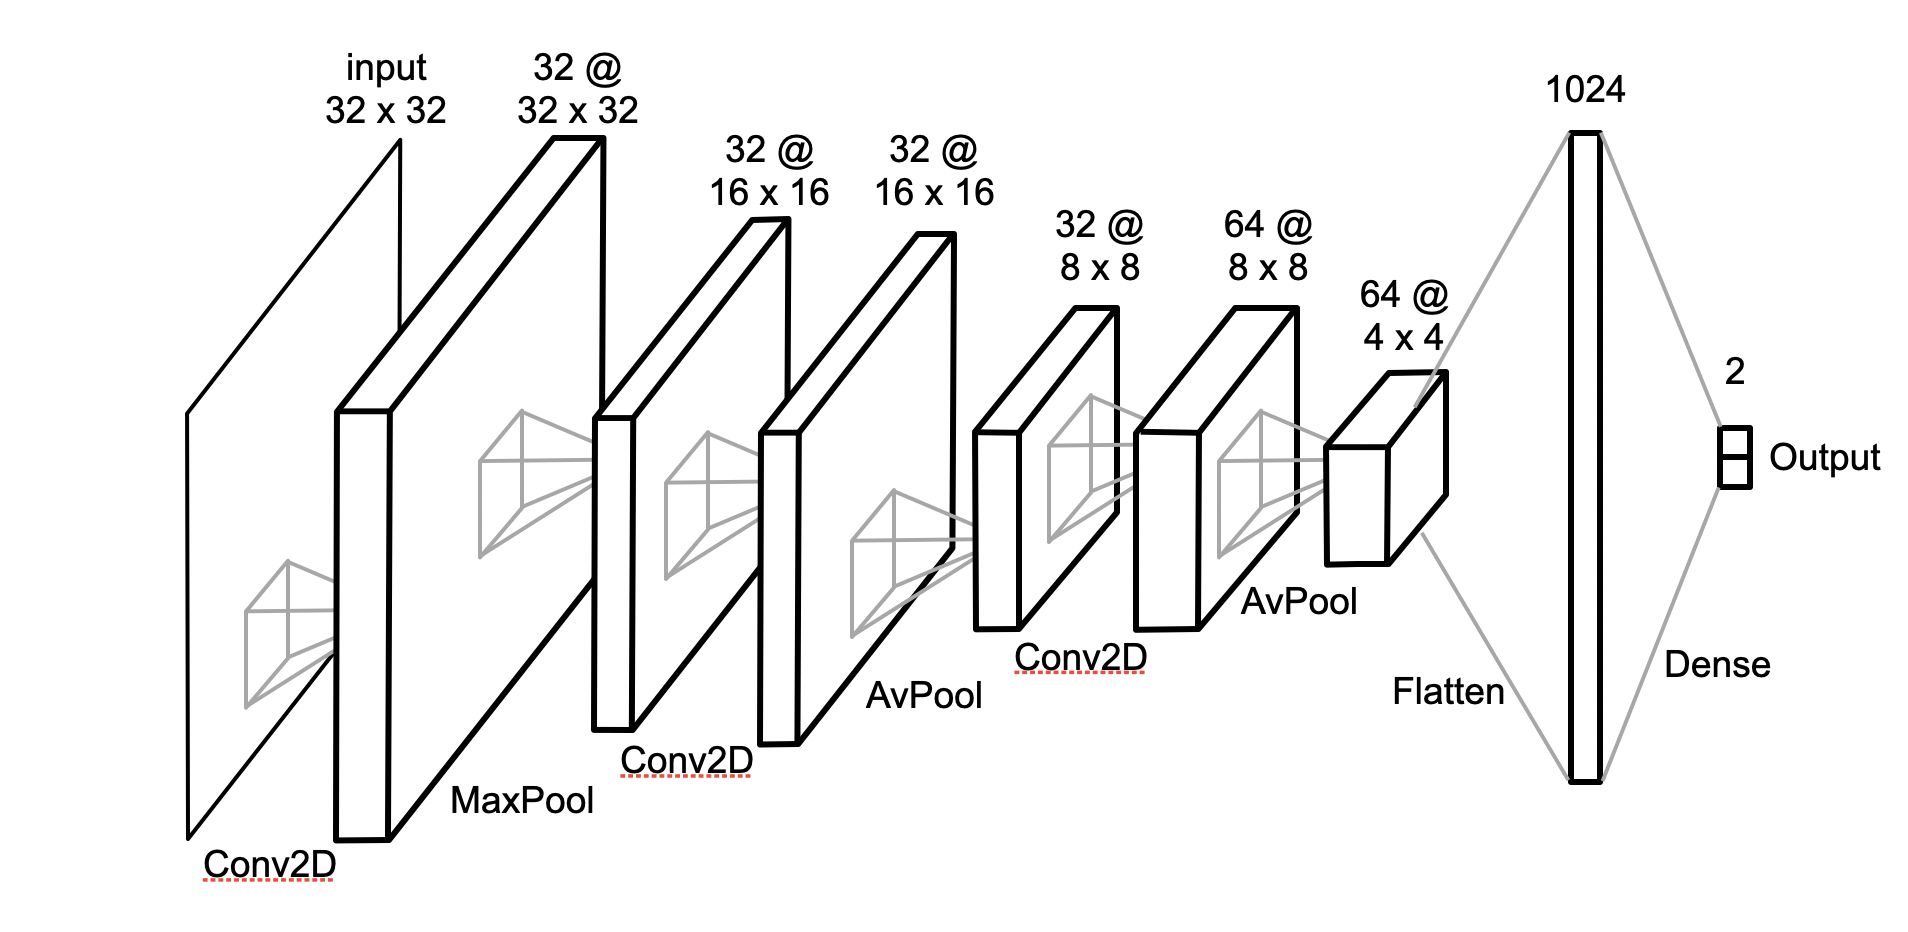

# **Part 3.2 [As a class, 15 mins]: Discuss calculation of the number of parameters needed for the CNN architecture shown in the figure**

###**Layer-wise Parameter Calculation**


**Conv2D Layer 1:**

Assuming grayscale input, it would be 32×32×1 (otherwise for RGB 32×32×3)

Filters: 32

Kernel size: 3×3

Parameters per filter (grayscale input): 3×3×1+1=10

Total parameters: 32×10=320


**MaxPooling Layer:**
No parameters.


**Conv2D Layer 2:**
Input: 32×32×32

Filters: 32

Kernel size: 3×3

Parameters per filter: 3×3×32+1=289

Total parameters: 32×289=9248


**Average Pooling Layer:**
No parameters.


**Conv2D Layer 3:**
Input: 16×16×32

Filters: 64

Kernel size: 3×3

Parameters per filter: 3×3×32+1=289

Total parameters: 64×289=18496


**Average Pooling Layer:**
No parameters.


**Flatten Layer:**
No parameters.


**Dense Layer:**
Input: 4×4×64=1024

Output: 2

Parameters: 1024×2+2=2050


**Total Parameters**
Conv2D Layers: 320+9248+18496=28064

Dense Layer: 2050

Total: 30114

Proportion of Dense Layer Parameters

Dense layer parameters: 2050

Total parameters: 30114

Proportion: 2050/30114≈6.8%


**Impact of Doubling Image Size**
New Input Size: 64×64

New Flatten Layer Size: 64×8×8=4096

New Dense Layer Parameters: 4096×2+2=8194


###**Summary**
* The total number of parameters for the given CNN architecture is `30114`.
* The dense layer has `2050` parameters, making up approximately `6.8%` of the total parameters.
* Doubling the input image size while keeping the Conv2D kernel sizes the same will not change the number of Conv2D parameters. However, it will increase the flattened layer size to `4096`, resulting in `8194` parameters in the dense layer.


# **Part 3.3 [Student, 25 mins]: Implement a CNN to classify MNIST dataset**
Now, try to implement the network similar to the one in the figure, but for oue MNIST dataset, which is a set of small images (28x28) that contain 10 different items (numbers).

This means, we want to have:

* The input image specified as a 28x28 image (not 32x32 like in the figure)
* 3 convolution layers, with the number of filters matching the figure
* 2 pooling layers (one max and one average)
* 10 classes for the classification at the end, one for each digit in the MNIST dataset, rather than 2 classes (binary) as shown in the image.

Try to adapt the code that we went through in parts 1-2 for building a simple CNN in order to build the model we want here. You can use ChatGPT to help.

Note: Implementing this CNN serves to illustrate how such models are built and trained. The focus here is on understanding the architecture rather than optimising the model.

In [ ]:
# Note:  We are intentionally using smaller subsets of the data (n_train = 300, n_valid = 100)
# for this teaching example. This is part of the exploration process and is meant
# to help illustrate the concepts and methods more clearly and quickly. In practice,
# for best performance, models would typically be trained on all available data.
# However, exploring the limits of a method with smaller subsets can be informative.

# Some key parameters
n_train = 300
n_valid = 100
# Define the number and size of hidden layers
hiddensizes = [32, 32, 64]  # number of kernels in each convlayer
# Define the activation function to be used by hidden layers
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [ ]:
# Note: learningrate=0 in the function call is used as a placeholder to ensure that the user
# explicitly specifies a learning rate when calling the function.
# This approach is more of a safeguard to prevent the model from
# training with an unintended default value, which might be too high or too low.
# It is also common to set a reasonable default learning rate and
# allow users to override it as needed.

# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):  #
    model = keras.models.Sequential()
    # First Conv Layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same",
                                  input_shape=[28, 28, 1]))  # Input shape for MNIST dataset
    model.add(keras.layers.MaxPooling2D(pool_size=2))  # Max Pooling
    # Intermediate Conv Layers
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))
        model.add(keras.layers.AveragePooling2D(pool_size=2))  # Average Pooling
    # Last Conv Layer
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))
    # Flatten and Dense Layers
    model.add(keras.layers.Flatten())  # Flatten to 1D
    model.add(keras.layers.Dense(10, activation="softmax"))  # Output layer with 10 classes for MNIST
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
# Create the model
model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)

# We can check a summary of the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 average_pooling2d_2 (Avera  (None, 7, 7, 32)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_12 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 flatten_3 (Flatten)         (None, 3136)             

In [ ]:
# Now, we can compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.001), metrics=["accuracy"])

In [ ]:
# We can train in our model
history = model.fit(X_train,y_train, epochs=5, validation_data=(X_valid, y_valid), batch_size=32)

Epoch 1/5
1719/1719 [==============================] - 60s 35ms/step - loss: 0.5927 - accuracy: 0.8382 - val_loss: 0.2801 - val_accuracy: 0.9152
Epoch 2/5
1719/1719 [==============================] - 56s 32ms/step - loss: 0.2567 - accuracy: 0.9235 - val_loss: 0.1977 - val_accuracy: 0.9410
Epoch 3/5
1719/1719 [==============================] - 59s 34ms/step - loss: 0.1777 - accuracy: 0.9467 - val_loss: 0.1274 - val_accuracy: 0.9654
Epoch 4/5
1719/1719 [==============================] - 56s 33ms/step - loss: 0.1340 - accuracy: 0.9599 - val_loss: 0.1111 - val_accuracy: 0.9654
Epoch 5/5
1719/1719 [==============================] - 59s 34ms/step - loss: 0.1108 - accuracy: 0.9665 - val_loss: 0.0991 - val_accuracy: 0.9714


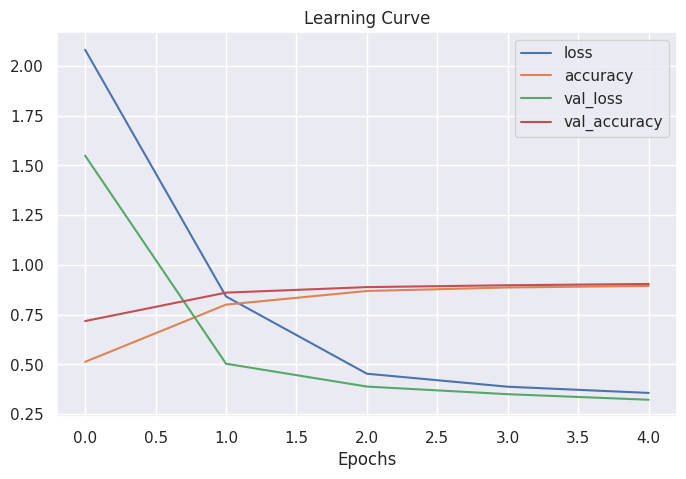

In [ ]:
# We can check the peformance of our model in a plot
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.grid(True)  # Optional: add grid for better readability
plt.legend(loc='best')  # Optional: place legend in the best position
plt.show()

#**Extension: Transforming a CNN into a Fully Convolutional Network (FC)**

If you have completed the main CNN task and have some extra time, you can explore this extra content. This example shows how you can modify the CNN to become a Fully Convolutional Network (FCN). This involves replacing the Flatten and Dense layers with a Convolutional layer that generates a single output per filter. This involves:

**1. Replacing the Flatten and Dense Layers with a Convolutional Layer:**

* The line model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax")) replaces the final dense layer with a convolutional layer. Here, the kernel size is set to 7 to match the reduced spatial dimensions after the pooling operations.

* This transformation means the network will generate a single output per filter using a convolutional layer instead of a dense layer. Each of the 10 filters corresponds to one of the 10 classes in the MNIST dataset.

**2. Building a Dense Neural Network (DNN):**

* The function model_dense_factory builds a traditional Dense Neural Network without any convolutional layers.

* This model first flattens the input image, then passes it through several dense layers defined by hiddensizes, and finally outputs predictions for the 10 classes using a softmax activation.




In [ ]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter
#  which requires the convolution to be "valid" = no padding and not "same" = add zero padding

In [ ]:
# Note: This factory function is quite fragile as it assumes the input image size is fixed (28x28x1 for MNIST).
#    If the input image size changes, either due to different initial dimensions or varying pooling layers,
#    the model will fail to compile or will produce unexpected results.
#    To handle varying input sizes, the code would need to dynamically track and adjust the spatial dimensions.
#    Additionally, if the image size becomes smaller than the kernel size, it will throw an error.

def model_cnn_fcn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same",
                                  input_shape=[28, 28, 1]))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))
        model.add(keras.layers.AveragePooling2D(pool_size=2))
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))
    model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [ ]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
# The '-1' argument in the reshape function is a shorthand to automatically calculate
# the appropriate size for that dimension based on the other specified dimensions.
# In this context, '-1' means to use all available data, which is convenient as we
# don't need to manually specify the number of samples.
X_train = X_train.reshape((-1, 28, 28, 1))  # Num of batches, xdim,ydim,channels
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

# **Part 4 [As a class, 15 mins]: Implementing Early Stopping**

In some instances, we may want to implement early stopping to ensure that training stops early if the validation loss does not improve for 5 consecutive epochs, preventing issues like overfitting.

The `EarlyStopping` callback from Keras is designed to monitor a specified metric during training and stop the training process if the metric does not improve for a given number of epochs (patience).

In this code, the callback is configured to monitor the validation loss (`val_loss`), with a patience of 5 epochs. This means that if the validation loss does not improve for 5 consecutive epochs, the training will stop early.

The `restore_best_weights=True parameter` ensures that the model's weights are restored to the best performing weights (i.e., those with the lowest validation loss) observed during training.

Try playing around with the early stopping criteria and see how this changes the model's learning curves.

In [ ]:
def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, callbacks=None):
    if callbacks is None:
        callbacks = []

    model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train], y_train[:n_train], epochs=n_epochs, batch_size=batch_size,
                        callbacks=callbacks, validation_data=(X_valid[:n_valid], y_valid[:n_valid]))

    max_val_acc = np.max(history.history['val_accuracy'])
    return max_val_acc, history, model


In [ ]:
# Ensure that the data is reshaped to 4 dimensions
# The '-1' argument in the reshape function is a shorthand to automatically calculate
# the appropriate size for that dimension based on the other specified dimensions.
# In this context, '-1' means to use all available data, which is convenient as we
# don't need to manually specify the number of samples.
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [ ]:
# Note:  We are intentionally using smaller subsets of the data (n_train = 300, n_valid = 100)
# for this teaching example. This is part of the exploration process and is meant
# to help illustrate the concepts and methods more clearly and quickly. In practice,
# for best performance, models would typically be trained on all available data.
# However, exploring the limits of a method with smaller subsets can be informative.

# Set parameters
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
max_val_acc, history, model = do_all(
    hiddensizes=[32, 32, 64],
    actfn="elu",
    optimizer=keras.optimizers.SGD,
    learningrate=0.01,
    n_train=300,
    n_valid=100,
    n_epochs=200,
    batch_size=32,
    callbacks=[early_stopping_cb]
)

Epoch 1/200
10/10 [==============================] - 1s 61ms/step - loss: 2.2912 - accuracy: 0.0833 - val_loss: 2.2730 - val_accuracy: 0.1700
Epoch 2/200
10/10 [==============================] - 0s 37ms/step - loss: 2.2607 - accuracy: 0.1967 - val_loss: 2.2403 - val_accuracy: 0.3000
Epoch 3/200
10/10 [==============================] - 0s 38ms/step - loss: 2.2291 - accuracy: 0.2233 - val_loss: 2.2074 - val_accuracy: 0.2400
Epoch 4/200
10/10 [==============================] - 0s 37ms/step - loss: 2.1966 - accuracy: 0.2133 - val_loss: 2.1737 - val_accuracy: 0.3400
Epoch 5/200
10/10 [==============================] - 0s 34ms/step - loss: 2.1624 - accuracy: 0.2700 - val_loss: 2.1342 - val_accuracy: 0.3600
Epoch 6/200
10/10 [==============================] - 0s 38ms/step - loss: 2.1194 - accuracy: 0.3367 - val_loss: 2.0897 - val_accuracy: 0.4500
Epoch 7/200
10/10 [==============================] - 0s 35ms/step - loss: 2.0701 - accuracy: 0.3600 - val_loss: 2.0431 - val_accuracy: 0.5700
Epoch 

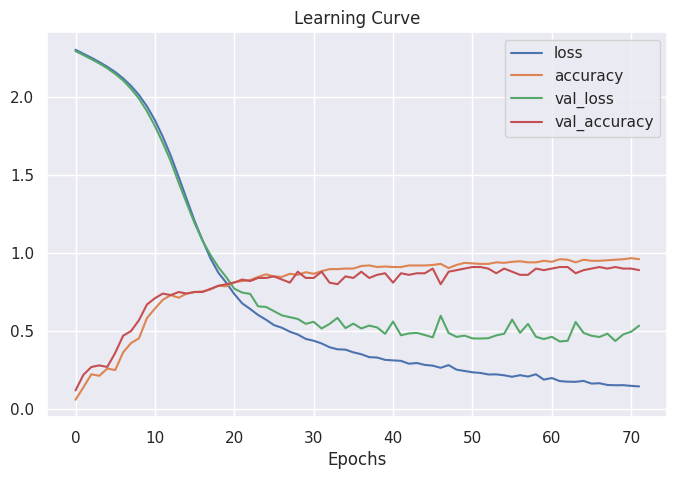

In [ ]:
# We can check the peformance of our model in a plot
pd.DataFrame(history.history).plot(figsize=(8 , 5))
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.grid(True)  # Optional: add grid for better readability
plt.legend(loc='best')  # Optional: place legend in the best position
plt.show()

#**Extension: Understanding How to Calculate the Number of Parameters in a 2D Convolutional Layer**

The code provided below calculates the number of parameters in a 2D convolutional layer. This is provided to further help you understand the complexity of the model and the amount of computation required.




In [ ]:
# How you can get the parameters in a 2dConv?

# Parameters in a 2dConv layer
# ((kernel_height* kernel_width*number_channels)+1)*num_kernels

# Example first Conv2d
print("Parameters in first Conv2D: ", ((3*3*1)+1)*16)

# Example second Conv2d
print("Parameters in second Conv2D: ", ((3*3*16)+1)*32)